In [1]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models

from torch.optim import lr_scheduler

from torchsummary import summary

from torch.utils.data import DataLoader
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

with urlopen(URL) as zipped:
    with ZipFile(BytesIO(zipped.read())) as zfile:
        zfile.extractall('')

train_dir = "cats_and_dogs_filtered/train"
val_dir   = "cats_and_dogs_filtered/validation"

In [3]:
# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [4]:
transform = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize(0.0, 1.0)])

train_data = ImageFolder(train_dir, transform = transform)
val_data = ImageFolder(val_dir, transform = transform)

In [5]:
train_data

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: cats_and_dogs_filtered/train
    StandardTransform
Transform: Compose(
               Resize(size=(160, 160), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=0.0, std=1.0)
           )

In [6]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=True)

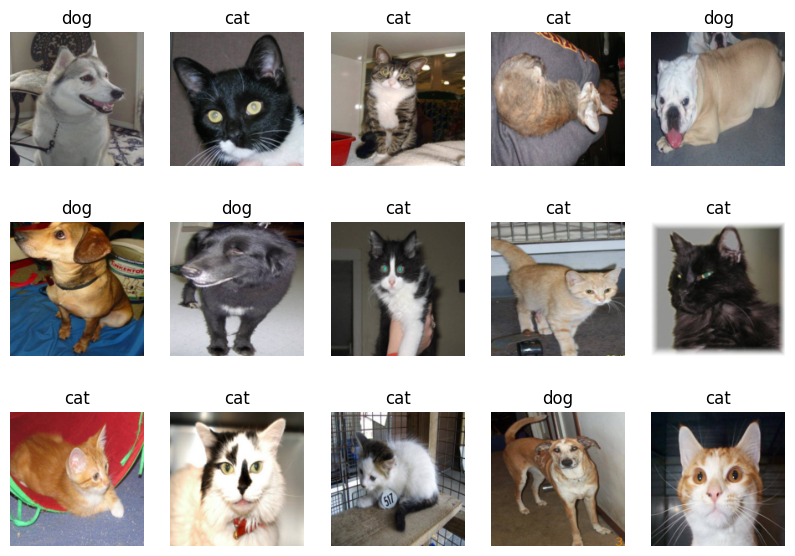

In [7]:
from matplotlib import pyplot as plt
import numpy as np

classes = ("cat", "dog")

n_rows = 3
n_cols = 5

fig, axarr = plt.subplots(n_rows, n_cols, figsize = (10, 7))

tl = iter(train_loader)

for i in range(n_rows):

    # returns batch_size images with their labels
    X, y = next(tl) 

    # populate a row with the images in the batch
    for j in range(n_cols):
        img = np.moveaxis(X[j].numpy(), 0, 2) 
        axarr[i, j].imshow(img )
        axarr[i, j].axis("off")
        axarr[i, j].set(title = classes[int(y[j])])

In [8]:
# same model as previous lecture

import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        # first convolutional layer
        # 3 color channels, 100 different kernels, kernel size = 5x5
        self.conv1 = nn.Conv2d(3, 100, 5)

        # shrinks the image by taking the largest pixel in each 2x2 square
        self.pool = nn.MaxPool2d(2, 2)

        # MOAR CONVOLUTION
        # 100 channels (from previous kernels), 50 new kernels, kernel size = 3x3
        self.conv2 = nn.Conv2d(100, 50, 3)

        # EVEN MOAR CONVOLUTION
        self.conv3 = nn.Conv2d(50, 20, 3)

        # a few complete layers for good measure
        self.fc1 = nn.Linear(6480, 80)
        self.fc2 = nn.Linear(80, 40)
        self.fc3 = nn.Linear(40, 10)

    def forward(self, x):

        # these two layers use the spatial structure of the image
        # so we don't flatten yet
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # now we're ready to flatten all dimensions except batch
        x = torch.flatten(x, 1) 

        # pass results through fully connected linear layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ConvNet().to(device)

In [9]:
INPUT_SHAPE = (3, 160, 160)

summary(model, INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 100, 156, 156]           7,600
         MaxPool2d-2          [-1, 100, 78, 78]               0
            Conv2d-3           [-1, 50, 76, 76]          45,050
         MaxPool2d-4           [-1, 50, 38, 38]               0
            Conv2d-5           [-1, 20, 36, 36]           9,020
         MaxPool2d-6           [-1, 20, 18, 18]               0
            Linear-7                   [-1, 80]         518,480
            Linear-8                   [-1, 40]           3,240
            Linear-9                   [-1, 10]             410
Total params: 583,800
Trainable params: 583,800
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.29
Forward/backward pass size (MB): 26.21
Params size (MB): 2.23
Estimated Total Size (MB): 28.73
-----------------------------------------

In [11]:
import torch.optim as optim

def train(model,  data_loader, optimizer, k_epochs = 1, print_every = 2000):

    # loss function is cross-entropy (multiclass logistic)
    loss_fn = nn.CrossEntropyLoss() 

    # optimizer is Adam, which does fancier stuff with the gradients
    
    for epoch in range(k_epochs): 

        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):

            # extract a batch of training data from the data loader
            X, y = data
            X = X.to(device)
            y = y.to(device)

            # zero out gradients: we're going to recompute them in a moment
            optimizer.zero_grad()

            # compute the loss (forward pass)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            # compute the gradient (backward pass)
            loss.backward()

            # Adam uses the gradient to update the parameters
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # print the epoch, number of batches processed, and running loss 
            # in regular intervals
            if i % print_every == print_every - 1:    
                print(f'[epoch: {epoch + 1}, batches: {i + 1:5d}], training loss: {running_loss / print_every:.3f}')
                running_loss = 0.0

    print('Finished Training')

optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, optimizer, k_epochs = 5, print_every = 10)

[epoch: 1, batches:    10], training loss: 1.307
[epoch: 1, batches:    20], training loss: 0.724
[epoch: 1, batches:    30], training loss: 0.702
[epoch: 1, batches:    40], training loss: 0.721
[epoch: 1, batches:    50], training loss: 0.745
[epoch: 1, batches:    60], training loss: 0.724
[epoch: 2, batches:    10], training loss: 0.829
[epoch: 2, batches:    20], training loss: 0.733
[epoch: 2, batches:    30], training loss: 0.736
[epoch: 2, batches:    40], training loss: 0.711
[epoch: 2, batches:    50], training loss: 0.693
[epoch: 2, batches:    60], training loss: 0.702
[epoch: 3, batches:    10], training loss: 0.691
[epoch: 3, batches:    20], training loss: 0.683
[epoch: 3, batches:    30], training loss: 0.705
[epoch: 3, batches:    40], training loss: 0.692
[epoch: 3, batches:    50], training loss: 0.697
[epoch: 3, batches:    60], training loss: 0.692
[epoch: 4, batches:    10], training loss: 0.702
[epoch: 4, batches:    20], training loss: 0.685
[epoch: 4, batches: 

In [12]:
def test(model, data_loader):
    correct = 0
    total = 0
    # torch.no_grad creates an environment in which we do NOT store the 
    # computational graph. We don't need to do this because we don't care about 
    # gradients unless we're training
    with torch.no_grad():
        for data in data_loader:
            X, y = data
            X = X.to(device)
            y = y.to(device)
            
            # run all the images through the model
            y_hat = model(X)

            # the class with the largest model output is the prediction
            _, predicted = torch.max(y_hat.data, 1)

            # compute the accuracy
            total += y.size(0)
            correct += (predicted == y).sum().item()

    print(f'Test accuracy: {100 * correct // total} %')

test(model, val_loader)

Test accuracy: 56 %


## Data Augmentation Transforms

In [13]:
augmentation_transform = transforms.Compose([transforms.Resize(IMG_SIZE), 
                                transforms.ToTensor(), 
                                transforms.RandomHorizontalFlip(), 
                                transforms.RandomRotation(90),
                                transforms.Normalize(0.0, 1.0)])

train_data = ImageFolder(train_dir, transform = augmentation_transform)

val_data = ImageFolder(val_dir, transform = transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=True)

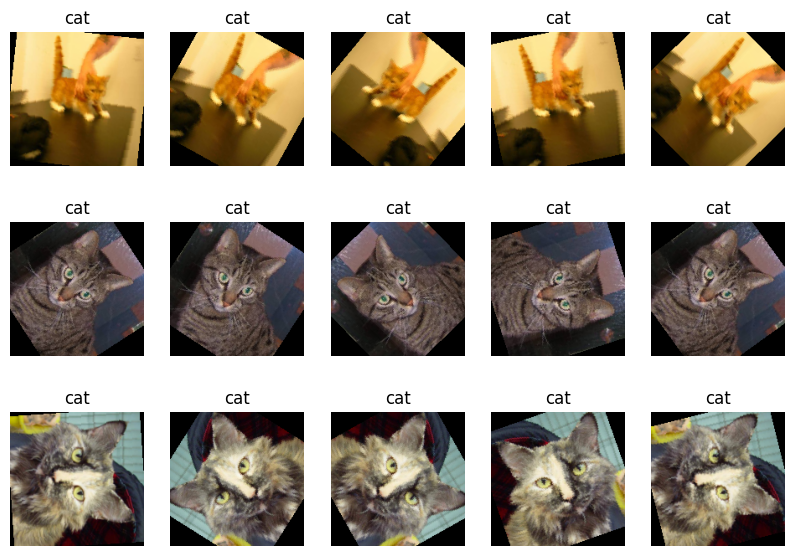

In [14]:
from matplotlib import pyplot as plt
import numpy as np

classes = ("cat", "dog")

n_rows = 3
n_cols = 5

fig, axarr = plt.subplots(n_rows, n_cols, figsize = (10, 7))

for i in range(n_rows):
    for j in range(n_cols):
    # returns batch_size images with their labels
        X, y = train_data[i]

        img = np.moveaxis(X.numpy(), 0, 2) 
        axarr[i, j].imshow(img )
        axarr[i, j].axis("off")
        axarr[i, j].set(title = classes[int(y)])

In [15]:
train(model, train_loader, optimizer, k_epochs = 5, print_every = 10)
test(model, val_loader)

[epoch: 1, batches:    10], training loss: 0.675
[epoch: 1, batches:    20], training loss: 0.681
[epoch: 1, batches:    30], training loss: 0.688
[epoch: 1, batches:    40], training loss: 0.708
[epoch: 1, batches:    50], training loss: 0.693
[epoch: 1, batches:    60], training loss: 0.691
[epoch: 2, batches:    10], training loss: 0.680
[epoch: 2, batches:    20], training loss: 0.689
[epoch: 2, batches:    30], training loss: 0.689
[epoch: 2, batches:    40], training loss: 0.687
[epoch: 2, batches:    50], training loss: 0.699
[epoch: 2, batches:    60], training loss: 0.682
[epoch: 3, batches:    10], training loss: 0.695
[epoch: 3, batches:    20], training loss: 0.681
[epoch: 3, batches:    30], training loss: 0.693
[epoch: 3, batches:    40], training loss: 0.699
[epoch: 3, batches:    50], training loss: 0.680
[epoch: 3, batches:    60], training loss: 0.690
[epoch: 4, batches:    10], training loss: 0.691
[epoch: 4, batches:    20], training loss: 0.687
[epoch: 4, batches: 

## Transfer Learning

In [46]:
model = models.resnet18(weights='IMAGENET1K_V1')

In [47]:
model = model.to(device)
summary(model, INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           9,408
       BatchNorm2d-2           [-1, 64, 80, 80]             128
              ReLU-3           [-1, 64, 80, 80]               0
         MaxPool2d-4           [-1, 64, 40, 40]               0
            Conv2d-5           [-1, 64, 40, 40]          36,864
       BatchNorm2d-6           [-1, 64, 40, 40]             128
              ReLU-7           [-1, 64, 40, 40]               0
            Conv2d-8           [-1, 64, 40, 40]          36,864
       BatchNorm2d-9           [-1, 64, 40, 40]             128
             ReLU-10           [-1, 64, 40, 40]               0
       BasicBlock-11           [-1, 64, 40, 40]               0
           Conv2d-12           [-1, 64, 40, 40]          36,864
      BatchNorm2d-13           [-1, 64, 40, 40]             128
             ReLU-14           [-1, 64,

In [48]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [50]:
# train with the complete model
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, optimizer, k_epochs = 2)
test(model, val_loader)

Finished Training
Test accuracy: 83 %


In [51]:
# instead train only the parameters of the final layer
# can be around 50% faster

model = models.resnet18(weights='IMAGENET1K_V1')
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [52]:
train(model, train_loader, optimizer, k_epochs = 2)
test(model, val_loader)

Finished Training
Test accuracy: 92 %
